In [40]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# One Hot Encodeing
categorises data points using one hot encodeing to categorizes into the 5 categories

In [41]:
class One_hot_encodeing():
    def __init__(self,data,categories):
        self.categories = categories
        self.data = data
        self.Y_one_hot = np.zeros(shape=(data.shape[0],self.categories.shape[0]))
        
    def encode(self):
        for index,cat in enumerate(self.data[:,-1]):
            index_cat = np.where(cat == self.categories)
            self.Y_one_hot[index][index_cat] = 1
        return self.Y_one_hot

# Image Extraction
Itirares through the folder going into every sub folder and using the sub folder name as category tag 

for the image files in the sub folder. Tag is used in one hot encodeing

In [42]:
class Image_Extraction_from_file:
    def __init__(self,path_folder):
        self.path_folder = path_folder
        self.image_data = np.empty((28*28))
        
        
    def Get_images(self,image_path):
        # function used to extract the image pixel data into an 1D array
        image = Image.open(image_path)
        image_array = np.array(image.getdata(),dtype=np.int32)/256
        #append the image data into image data array which will contain all the image data with the category lable 
        self.image_data.append(image_array)
        
    def Extract_from_folder(self):
        category_name = []
        self.image_data = []
        #itirate through the main folder
        for root, dirs, files in os.walk(self.path_folder):
            for name in files:
                if name.endswith(".png"):
                    image_path = os.path.join(root, name)
                    self.Get_images(image_path)
                    subdir_name = os.path.basename(root)  
                    category_name.append(subdir_name)
        
        self.image_data = np.array(self.image_data)
        category_name = np.array(category_name).reshape(-1, 1) 
        unique_cat_list = np.unique(category_name)
        # Combine image data with labels
        self.image_data = np.hstack((self.image_data, category_name))
        encode_one_hot = One_hot_encodeing(self.image_data,unique_cat_list)
        self.Y_one_hot = encode_one_hot.encode()
        self.X_images = self.image_data[:,:-1].astype(float)
        # Rnadomeise the sequence of data
        indices = np.random.permutation(self.X_images.shape[0])
        #same indices used to randomise both x and y
        self.X_images = self.X_images[indices]
        self.Y_one_hot = self.Y_one_hot[indices]
        return self.X_images,self.Y_one_hot
        

# GET image Data

In [43]:
path_train = "Train"
path_test = "Test"
Train_file = Image_Extraction_from_file(path_train)
Test_file = Image_Extraction_from_file(path_test)

In [44]:
X_images_train,Y_images_train = Train_file.Extract_from_folder()
X_images_test,Y_images_test = Test_file.Extract_from_folder()

In [45]:
X_images_train = np.random.randn(500,784)
Y_images_train = np.random.randn(500,5)

# LAYER CLASS
This class contains the hidden layers.

Layers are divided into hidden and output based on their internal activation functions.

The hidden layers contain the ReLU activation function, with He initialization of weights in the constructor to prevent extreme values in weights. This helps avoid activation explosion and cost divergence into NaN or infinity, which could cause the loss to eventually increase.


In [46]:
class Layers_hidden:
    def __init__(self,Weights_no,neuron_no):
        self.weights = self.weights = np.random.randn(neuron_no, Weights_no) * np.sqrt(2 / Weights_no) #HE initialization
        self.bias = np.random.randn(neuron_no)
        
    def ReLU(self,x):
        return np.maximum(x,0)
    
    def Process(self,input):
        self.input = input
        self.y = np.add(np.dot(self.input,self.weights.T) , self.bias) #gives an array of output with no of elements  = no of neuron
        self.z = self.ReLU(self.y) #activation function based of the layer being used
        self.output_layer_hidden = self.z
        return self.z
    
    def Backward_propogation_hidden(self,dvalue,learning_rate):
      
        self.dw = np.dot(dvalue.T,self.input)/self.input.shape[0]
        self.dx = np.dot(dvalue, self.weights)
        self.db = np.sum(dvalue, axis=0) / self.input.shape[0]
        self.update_parameters(learning_rate)
        
        return self.dx
    
    def update_parameters(self, learning_rate):
        self.weights = self.weights + learning_rate * self.dw 
        self.bias = self.bias + learning_rate * self.db
       

# LAYER OUTPUT
He initialization is used.

In the output layer, the Softmax function is used to convert the output into probabilities for each category.

The Cross-Entropy loss function is used to measure the multi-class classification prediction with true labels.


In [47]:
class Layer_output:
    def __init__(self,Weights_no,neuron_no):
        self.weights = self.weights = np.random.randn(neuron_no, Weights_no) * np.sqrt(2 / Weights_no) #HE initialization
        self.bias = np.random.randn(neuron_no)
        
    
    def Softmax(self,x):
        x = x - np.max(x, axis=1, keepdims=True)  # Subtract max per row
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
    
    
    def Process(self,input):
        self.input = input
        self.y = np.add(np.dot(self.input,self.weights.T) , self.bias)  #gives an array of output with no of elements  = no of neuron this is for output layer
        self.z = self.Softmax(self.y)
        self.output_layer = self.z
        return self.z
    
    def Cross_entropy_loss(self,Y_actual):
        cost = (-(np.sum(np.multiply(Y_actual,(np.log(self.output_layer + 1e-5))))))
        normalised_cost = np.sum(cost)/self.input.shape[0]
        return normalised_cost
    
    def Backward_propogation_output(self,yactual,learning_rate):
        self.LR = learning_rate
        self.dw = np.dot((np.subtract(yactual ,self.output_layer)).T,self.input)
        self.dx = np.dot(np.subtract(yactual , self.output_layer),self.weights)
        self.db = np.subtract(yactual ,self.output_layer)
        self.update_parameters(self.LR)
        return self.dx
    
    
    def update_parameters(self,learning_rate):
        self.weights = self.weights + learning_rate * self.dw/self.input.shape[0]
        self.bias = self.bias + learning_rate * np.sum(self.db,axis =0)/self.input.shape[0]
        

# TEST TRAIN
## Constructor
Used to initialize the objects of classes LayerHidden and LayerOutput. The objects are initialized by implementing the network once, as the layers are interconnected. The number of neurons in layer n-1 is equal to the number of weights in each neuron in layer n. The output layer should have neurons equal to the number of categories.

## Training
This function executes through layers. The output is fed to the cost function. The normalized loss is used in gradient descent.

Gradient descent calls the backpropagation function of the layers. Here, the layers are iterated from backward, starting from the output layer. The model parameters, such as weights and biases, are updated accordingly.

This is iterated multiple times with an adequate learning rate.


In [56]:
class Train_Test_Neural_network:
    def __init__(self,layer_info,X_train,Y_train,X_test,Y_test):
        self.no_Layers = len(layer_info)-1
        self.Layer_size = layer_info
        self.Layer = []
        self.LR_his = []
        self.loss_in_one_itiration = 0
        self.Loss = []
        self.X_train = X_train
        self.Y_train= Y_train
        self.X_train_scrap = X_train[0, : ]
        self.X_test = X_test
        self.Y_test = Y_test
        self.dw = 0
        self.dx =0
        self.db = 0
        for i in range(self.no_Layers):
           
            self.Layer.append(Layers_hidden(len(self.X_train_scrap),self.Layer_size[i])) #making of object list and inisializing parameters.
            self.X_train_scrap = self.Layer[i].Process(self.X_train_scrap)
        self.Layer_last = Layer_output(len(self.X_train_scrap),self.Layer_size[i+1])  
        
    def execute_through_layers(self,X):
        for i in range(self.no_Layers):
            X = self.Layer[i].Process(X)
        self.X_last = self.Layer_last.Process(X)
           
    
    def gradient_descent(self,Y_test):
        self.Y_test_1 = Y_test
        n = self.no_Layers
        self.dx_last_layer = self.Layer_last.Backward_propogation_output(self.Y_test_1,self.LR)
        for j in range(n - 1, -1, -1):
            self.dx_last_layer = self.Layer[j].Backward_propogation_hidden(self.dx_last_layer,self.LR)
            
    def Train_layers(self,itirations,learning_rate):
        self.LR = learning_rate
        for i in range(itirations):
            
            self.execute_through_layers(self.X_train) # this function is called to execute through layers each time
            self.loss_in_one_itiration =  (self.Layer_last.Cross_entropy_loss(self.Y_train))  # to save the Cross entropy loss in each itiration
            self.gradient_descent(self.Y_train)
            self.loss_in_one_itiration = np.average(self.loss_in_one_itiration)
            self.Loss.append(self.loss_in_one_itiration)
            self.LR_his.append(self.LR)
            
    def Test_model(self,):
        
        self.execute_through_layers(self.X_test)
        self.Y_predict = self.X_last
        return self.Y_predict

## Layer info
no of neurnos can be constomised by making an array with each element representing number of neurnons in each layer


In [57]:
Layer_info = np.array([X_images_train.shape[1],512,256,128,64,32,5])

## Train the model with optimum number of neurons and layers for adequate no of itirations

In [58]:
Neural_network = Train_Test_Neural_network(Layer_info,X_images_train,Y_images_train,None,None)
Neural_network.Train_layers(2500,0.001)

# Cost VS Epoch
Visualizing the Decreasing cost in Training

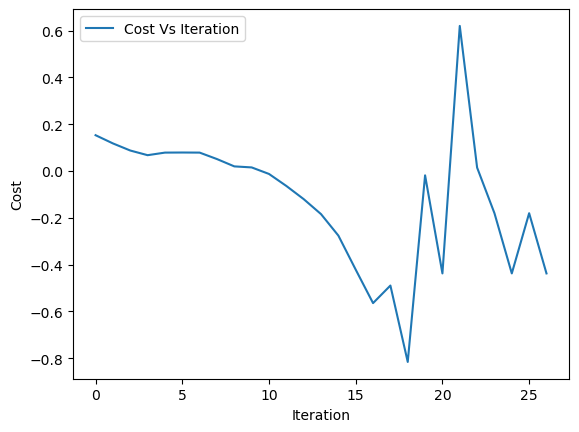

In [59]:
plt.plot(range(len(Neural_network.Loss)),Neural_network.Loss,label ='Cost Vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend()
plt.show()

## Pedict the test values

In [53]:
predict = Neural_network.Test_model()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

# Computes performsnce metrics for the model

In [ ]:

y_pred_classes = np.argmax(predict, axis=1)

# Convert true one-hot labels to class labels
y_true_classes = np.argmax(Y_images_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
recall= recall_score(y_true_classes, y_pred_classes,average='macro')
precision = precision_score(y_true_classes, y_pred_classes,average='macro')
f1_ = f1_score(y_true_classes, y_pred_classes,average='macro')


In [ ]:
print(f"Accuracy = {accuracy}\nPrecision = {precision}\nRecall = {recall}\nF1 score = {f1_}\n ")

Accuracy = 0.951
Precision = 0.9511168929073783
Recall = 0.951
F1 score = 0.950968767066179
 
